<a href="https://colab.research.google.com/github/mashaan14/YouTube-channel/blob/main/notebooks/2024_01_31_SGC_and_ASGC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Graph Convolution (SGC) and Adaptive Simple Graph Convolution (ASGC)

I borrowed some code from these resources:
  - https://github.com/Tiiiger/SGC
  - https://github.com/schariya/adaptive-simple-convolution/tree/main

## References:
```bibtex
@misc{wu2019simplifying,
  title         = {Simplifying Graph Convolutional Networks},
  author        = {Felix Wu and Tianyi Zhang and Amauri Holanda de Souza Jr. au2 and Christopher Fifty and Tao Yu and Kilian Q. Weinberger},
  year          = {2019},
  eprint        = {1902.07153},
  archivePrefix = {arXiv},
  primaryClass  = {cs.LG}
}
```

```bibtex
@misc{chanpuriya2022simplified,
  title         = {Simplified Graph Convolution with Heterophily},
  author        = {Sudhanshu Chanpuriya and Cameron Musco},
  year          = {2022},
  eprint        = {2202.04139},
  archivePrefix = {arXiv},
  primaryClass  = {cs.LG}
}
```

## Prepare libraries and data

In [ ]:
!pip install torch-geometric

In [ ]:
# Standard libraries
import math
import time
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch geometric
import torch_geometric
from torch_geometric.datasets import StochasticBlockModelDataset
from torch_geometric.utils import to_networkx
from torch_geometric.utils import to_dense_adj
from torch_geometric.transforms import RandomNodeSplit

In [ ]:
num_nodes_per_class = 100
num_nodes = [num_nodes_per_class] * 3
edge_probs1 = [[.2, .05, .02],
              [.05, .2, .02],
              [.02, .02, .2]]
edge_probs2 = [[.1, .05, .2],
              [.05, .1, .2],
              [.2, .2, .1]]
dataset1 = StochasticBlockModelDataset('./', num_nodes, edge_probs1, num_channels=10)
dataset2 = StochasticBlockModelDataset('./', num_nodes, edge_probs2, num_channels=10)

Processing...
Done!
Processing...
Done!


In [ ]:
colors = cm.tab10.colors
y1_colors = np.array(colors)[dataset1[0].y.numpy()]
y2_colors = np.array(colors)[dataset2[0].y.numpy()]

In [ ]:
dataset1[0]

Data(x=[300, 10], edge_index=[2, 7832], y=[300])

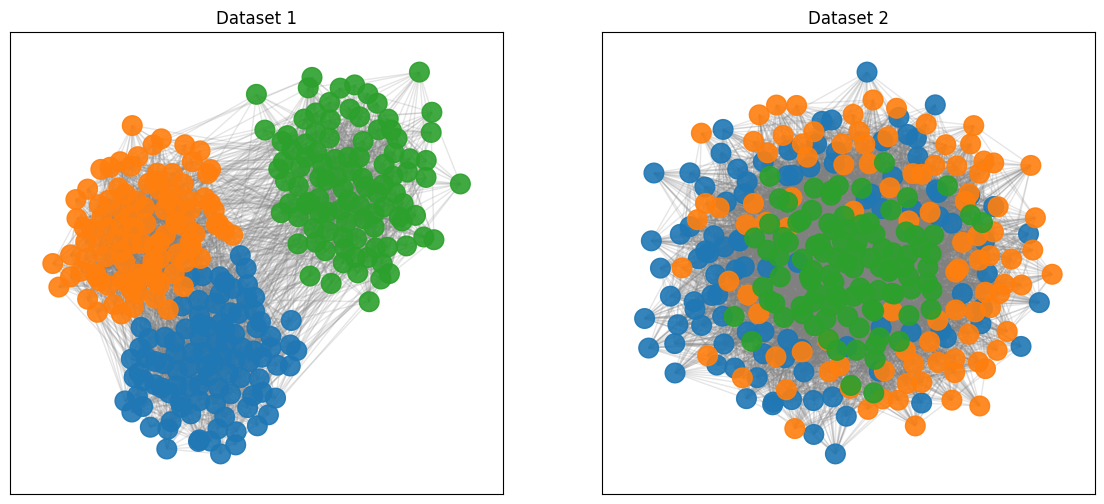

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

G = to_networkx(dataset1[0], to_undirected=True)
node_pos=nx.spring_layout(G, seed=0)
nx.draw_networkx_nodes(G, pos=node_pos, node_size=200, node_color=y1_colors, alpha=0.9, ax=ax1)
nx.draw_networkx_edges(G, pos=node_pos, edge_color="grey", alpha=0.2, ax=ax1)
ax1.set_title('Dataset 1')

G = to_networkx(dataset2[0], to_undirected=True)
node_pos=nx.spring_layout(G, seed=0)
nx.draw_networkx_nodes(G, pos=node_pos, node_size=200, node_color=y2_colors, alpha=0.9, ax=ax2)
nx.draw_networkx_edges(G, pos=node_pos, edge_color="grey", alpha=0.2, ax=ax2)
ax2.set_title('Dataset 2')

plt.show()

In [ ]:
data = []
split = RandomNodeSplit(num_val=0.1, num_test=0.5)
data.append(split(dataset1[0]))
data.append(split(dataset2[0]))

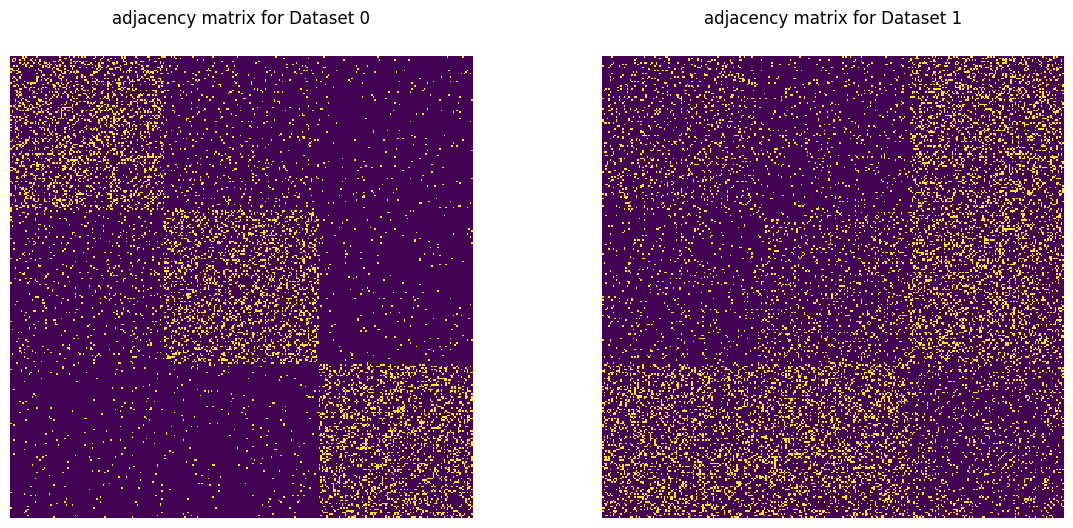

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

for i, d in enumerate(data):
  adj = to_dense_adj(d.edge_index)[0]
  # symmetric adjacency matrix
  adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
  axs[i].matshow(adj)
  axs[i].set_axis_off()
  axs[i].set_title('adjacency matrix for Dataset '+str(i))

plt.show()

In [ ]:
data_WebKB = []
data_WebKB.append(torch_geometric.datasets.WebKB('./', 'cornell'))
data_WebKB.append(torch_geometric.datasets.WebKB('./', 'texas'))

## SGC

In [ ]:
# source: https://github.com/schariya/adaptive-simple-convolution/blob/main/AdaptiveSimpleConvolution.ipynb
def feat_filter_SGC(feat, adj, K):
    n = adj.shape[0]
    adj_aug = adj + sp.sparse.eye(n)
    deg_aug = np.array(adj_aug.sum(axis=1)).flatten()
    adj_aug_norm = sp.sparse.spdiags(deg_aug**(-0.5),0,n,n) @ adj_aug @ sp.sparse.spdiags(deg_aug**(-0.5),0,n,n)

    feat_filter = feat
    for i in range(1,K+1):
        feat_filter = adj_aug_norm @ feat_filter
    return feat_filter

## ASGC

In [ ]:
# source: https://github.com/schariya/adaptive-simple-convolution/blob/main/AdaptiveSimpleConvolution.ipynb
def feat_filter_ASGC(feats, adj, K, reg_zero, return_coeffs=False, verbose=False):
    n, f = feats.shape

    deg = np.array(adj.sum(axis=1)).flatten()
    if 0 in deg:
        if verbose:
            print("Added self-loops where degree was 0.")
        idcs = np.argwhere(deg==0).flatten()
        vec = np.zeros(n)
        vec[idcs] = 1
        deg[idcs] = 1.
        adj_norm = sp.sparse.spdiags(deg**(-0.5),0,n,n) @ (adj+sp.sparse.spdiags(vec,0,n,n)) @ sp.sparse.spdiags(deg**(-0.5),0,n,n)
    else:
        adj_norm = sp.sparse.spdiags(deg**(-0.5),0,n,n) @ adj @ sp.sparse.spdiags(deg**(-0.5),0,n,n)

    feats_props = np.empty((K+1, n, f))
    feats_props[0,:,:] = feats

    for i in range(1,K+1):
        feats_props[i,:,:] = adj_norm @ feats_props[i-1,:,:]

    coeffs = np.empty((f, K+1))
    feats_filtered = np.empty((f,n))

    feats_props = np.transpose(feats_props, (2,1,0)) # now it is f x n x (K+1)
    reg_vec = np.zeros(K+1); reg_vec[0] = np.sqrt(n*reg_zero)

    for feat_idx in range(f):
        coeffs[feat_idx,:], _, _, _ = np.linalg.lstsq(np.vstack((feats_props[feat_idx,:,:], reg_vec[None,:])),
                                                      np.append(feats_props[feat_idx,:,0], np.zeros(1)),
                                                      rcond=None)
        feats_filtered[feat_idx,:] = feats_props[feat_idx,:,:] @ coeffs[feat_idx,:]
        if verbose:
            print("Finished feat %i of %i." % (feat_idx, f))

    feats_filtered = feats_filtered.T # now it's n x f

    if return_coeffs:
        return feats_filtered, coeffs
    else:
        return feats_filtered

## Classifier

In [ ]:
# source: https://github.com/Tiiiger/SGC/blob/master/models.py
class SGC(nn.Module):
    """
    A Simple PyTorch Implementation of Logistic Regression.
    Assuming the features have been preprocessed with k-step graph propagation.
    """
    def __init__(self, nfeat, nclass):
        super(SGC, self).__init__()

        self.W = nn.Linear(nfeat, nclass)

    def forward(self, x):
        return self.W(x)

## Training

In [ ]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [ ]:
def train_and_test(model, optimizer, features, labels, idx_train, idx_val, idx_test):
  loss_train_list = []
  loss_val_list = []

  for epoch in range(1000):
      model.train()
      optimizer.zero_grad()
      output = model(features[idx_train])
      loss_train = F.cross_entropy(output, labels[idx_train])
      loss_train_list.append(loss_train.item())
      acc_train = accuracy(output, labels[idx_train])
      loss_train.backward()
      optimizer.step()

      # Evaluate validation set performance separately,
      # deactivates dropout during validation run.
      with torch.inference_mode():
        model.eval()
        output = model(features[idx_val])
        loss_val = F.cross_entropy(output, labels[idx_val])
        loss_val_list.append(loss_val.item())
        acc_val = accuracy(output, labels[idx_val])

      # Print evaluation metrics every 100 epochs
      # if epoch % 100 == 0:
          # print(f'Epoch {epoch:>3} | Train Acc: {acc_train.item()*100:.2f}% | Validation Acc: {acc_val.item()*100:.2f}%')

  model.eval()
  with torch.inference_mode():
    output = model(features[idx_test])
    loss_test = F.cross_entropy(output, labels[idx_test])
    idx_test_preds = output.max(1)[1].type_as(labels)
    acc_test = accuracy(output, labels[idx_test])

  print(f'Test Acc: {acc_test.item()*100:.2f}% | Test loss: {loss_test.item():.2f}')

  return loss_train_list, loss_val_list, acc_test

In [ ]:
model_SGC = SGC(nfeat=data[0].x.shape[1],
            nclass=data[0].y.max().item() + 1)
optimizer_SGC = optim.Adam(model_SGC.parameters(), lr=1, weight_decay=0)

accuracy_list = []
dset = ['Dataset 1', 'Dataset 2']

for i, d in enumerate(data):
  adj = to_dense_adj(d.edge_index)[0]
  # force adj to be symmetric
  adj = adj.maximum(adj.T)
  features_SGC = feat_filter_SGC(d.x.numpy(), adj.numpy(), 2)
  features_SGC = torch.Tensor(features_SGC)
  labels = d.y
  idx_train = d.train_mask
  idx_val = d.val_mask
  idx_test = d.test_mask

  loss_train_list, loss_val_list, acc_test = train_and_test(model_SGC, optimizer_SGC, features_SGC, labels, idx_train, idx_val, idx_test)
  accuracy_list.append(['SGC', dset[i], acc_test.item()])
  print('----------------------------')

  features_ASGC = feat_filter_ASGC(d.x.numpy(), adj.numpy(), 2, 1e-2)
  features_ASGC = torch.Tensor(features_ASGC)

  loss_train_list, loss_val_list, acc_test = train_and_test(model_SGC, optimizer_SGC, features_ASGC, labels, idx_train, idx_val, idx_test)
  accuracy_list.append(['ASGC', dset[i], acc_test.item()])
  print('----------------------------')

Test Acc: 100.00% | Test loss: 0.00
----------------------------
Test Acc: 57.33% | Test loss: 0.87
----------------------------
Test Acc: 93.33% | Test loss: 0.17
----------------------------
Test Acc: 74.67% | Test loss: 0.80
----------------------------


In [ ]:
model_SGC = SGC(nfeat=data_WebKB[0].x.shape[1],
            nclass=data_WebKB[0].y.max().item() + 1)
optimizer_SGC = optim.Adam(model_SGC.parameters(), lr=1, weight_decay=0)

dset = ['cornell', 'texas']

for i, d in enumerate(data_WebKB):
  adj = to_dense_adj(d.edge_index)[0]
  # force adj to be symmetric
  adj = adj.maximum(adj.T)
  features_SGC = feat_filter_SGC(d.x.numpy(), adj.numpy(), 2)
  features_SGC = torch.Tensor(features_SGC)
  labels = d.y
  idx_train = d.train_mask[:,0]
  idx_val = d.val_mask[:,0]
  idx_test = d.test_mask[:,0]

  loss_train_list, loss_val_list, acc_test = train_and_test(model_SGC, optimizer_SGC, features_SGC, labels, idx_train, idx_val, idx_test)
  accuracy_list.append(['SGC', dset[i], acc_test.item()])
  print('----------------------------')

  features_ASGC = feat_filter_ASGC(d.x.numpy(), adj.numpy(), 2, 1e-2)
  features_ASGC = torch.Tensor(features_ASGC)

  loss_train_list, loss_val_list, acc_test = train_and_test(model_SGC, optimizer_SGC, features_ASGC, labels, idx_train, idx_val, idx_test)
  accuracy_list.append(['ASGC', dset[i], acc_test.item()])
  print('----------------------------')

Test Acc: 48.65% | Test loss: 43.06
----------------------------
Test Acc: 59.46% | Test loss: 44.53
----------------------------
Test Acc: 51.35% | Test loss: 228.64
----------------------------
Test Acc: 62.16% | Test loss: 216.44
----------------------------


## Plotting the results

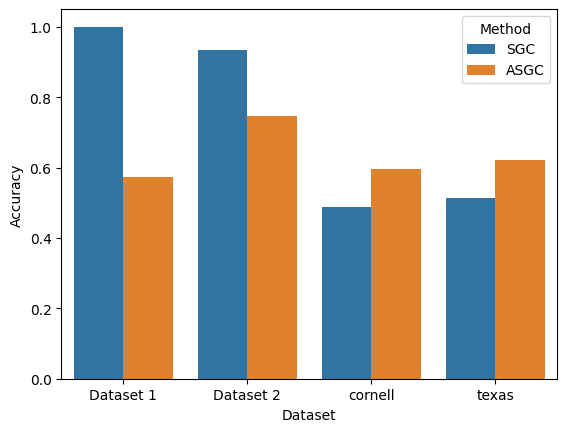

In [ ]:
df = pd.DataFrame(accuracy_list, columns=('Method', 'Dataset', 'Accuracy'))
sns.barplot(df,x='Dataset', y='Accuracy', hue='Method')
plt.show()